# Detector de Plazas de Aparcamiento
## Fundamentos de Visión por Computador - Proyecto Individual

**Objetivo**: Sistema de visión artificial para monitorizar en tiempo real el estado (Libre/Ocupado) de ~51 plazas de aparcamiento, siendo robusto a cambios drásticos de iluminación (sol y sombra).

**Metodología**: Visión Clásica (Computer Vision) basada en análisis de texturas y umbralización adaptativa.

**Ventajas sobre Deep Learning**:
- Computacionalmente ligero (no requiere GPU)
- No necesita miles de horas de entrenamiento
- Matemáticamente explicable
- Complejidad: $O(N)$ lineal con píxeles

---
## 1. Imports y Configuración

In [2]:
import cv2
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib para mejor visualización
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas correctamente")
print(f"   OpenCV versión: {cv2.__version__}")

✅ Librerías importadas correctamente
   OpenCV versión: 4.12.0


---
## 2. Carga de Configuración de Plazas

Las plazas fueron definidas manualmente usando `configurar_plazas.py`.  
Se monitorizan **51 plazas** en la zona central-derecha del parking para evitar oclusiones (árboles) y distorsiones de perspectiva.

In [3]:
# Cargar plazas desde archivo pickle
PLAZAS_FILE = "plazas.pickle"

if not Path(PLAZAS_FILE).exists():
    print(f"❌ Error: '{PLAZAS_FILE}' no encontrado.")
    print("   Ejecuta primero: python configurar_plazas.py")
else:
    with open(PLAZAS_FILE, 'rb') as f:
        plazas = pickle.load(f)
    
    print(f"✅ Cargadas {len(plazas)} plazas desde '{PLAZAS_FILE}'")
    print(f"\nEjemplo de primeras 3 plazas (x, y, w, h):")
    for idx, plaza in enumerate(plazas[:3]):
        print(f"   Plaza {idx+1}: {plaza}")

✅ Cargadas 51 plazas desde 'plazas.pickle'

Ejemplo de primeras 3 plazas (x, y, w, h):
   Plaza 1: (182, 368, 21, 53)
   Plaza 2: (201, 369, 22, 51)
   Plaza 3: (222, 372, 28, 47)


---
## 3. Pipeline de Procesamiento

### 3.1. Preprocesamiento

**A. Conversión a Escala de Grises**  
**Justificación**: El color del vehículo (rojo, azul, blanco) no es determinante para ocupación. La intensidad lumínica es suficiente y reduce la carga de procesamiento a 1/3 (1 canal vs 3 canales RGB).

**B. Suavizado Gaussiano**  
**Justificación**: Las cámaras digitales y la textura del asfalto generan ruido de alta frecuencia. El filtro Gaussiano suaviza la imagen para evitar falsos positivos en detección de bordes/textura.

In [4]:
def preprocesar_imagen(img):
    """
    Preprocesa la imagen para detección de plazas.
    
    Args:
        img: Imagen BGR de entrada
    
    Returns:
        Imagen en escala de grises suavizada
    """
    # A. Conversión a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # B. Suavizado Gaussiano (kernel 5x5)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    return blur

print("✅ Función de preprocesamiento definida")

✅ Función de preprocesamiento definida


### 3.2. Segmentación Adaptativa

**Umbralización Adaptativa (`cv2.adaptiveThreshold`)**

**Problema**: En el parking hay sombras enormes proyectadas por edificios. Un umbral simple (ej. "todo lo que sea más brillante que 127 es blanco") fallaría:
- Zonas de sol → completamente blancas
- Zonas de sombra → completamente negras
- Independiente de si hay coches o no

**Solución**: Este algoritmo calcula el umbral para cada pequeña vecindad de píxeles (bloque).

**Resultado**:
- Imagen binaria donde se destacan bordes y texturas locales
- **Plaza Vacía (Asfalto)**: Textura lisa → Pocos cambios → **Pocos píxeles blancos**
- **Plaza Ocupada (Coche)**: Muchos bordes (ventanillas, parachoques) → **Muchos píxeles blancos**

In [5]:
def umbralizar_adaptativo(img_blur, block_size=21, C=5):
    """
    Aplica umbralización adaptativa para detectar texturas locales.
    
    Args:
        img_blur: Imagen en escala de grises suavizada
        block_size: Tamaño de la vecindad para cálculo de umbral (debe ser impar)
        C: Constante que se resta del umbral calculado
    
    Returns:
        Imagen binaria (bordes/texturas en blanco)
    """
    # Umbralización adaptativa con ventana local Gaussiana
    # THRESH_BINARY_INV: Bordes y texturas aparecen en BLANCO
    binary = cv2.adaptiveThreshold(
        img_blur,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        C
    )
    
    return binary

print("✅ Función de umbralización adaptativa definida")

✅ Función de umbralización adaptativa definida


### 3.3. Post-procesamiento Morfológico

**Filtro de Mediana (`cv2.medianBlur`)**

**Justificación**: Tras el umbralizado, el asfalto viejo puede tener puntitos blancos aislados ("ruido de sal"). La mediana elimina estos puntos sin borrar los bordes fuertes de los vehículos.

In [6]:
def filtro_mediana(img_binary, kernel_size=5):
    """
    Aplica filtro de mediana para eliminar ruido de sal.
    
    Args:
        img_binary: Imagen binaria
        kernel_size: Tamaño del kernel (debe ser impar)
    
    Returns:
        Imagen binaria limpia
    """
    return cv2.medianBlur(img_binary, kernel_size)

print("✅ Función de filtro de mediana definida")

✅ Función de filtro de mediana definida


---
## 4. Clasificación y Decisión

### 4.1. Motor de Detección

Para cada plaza definida:
1. **Recorte**: Extraemos el ROI de la imagen binaria procesada
2. **Conteo**: Contamos píxeles blancos con `cv2.countNonZero()`
3. **Decisión**:
   - Si `Conteo_Píxeles > UMBRAL_DECISIÓN` → **OCUPADO**
   - Si `Conteo_Píxeles ≤ UMBRAL_DECISIÓN` → **LIBRE**

In [7]:
def detectar_ocupacion(img_binary, plazas, umbral_pixeles=500):
    """
    Detecta el estado de ocupación de cada plaza.
    
    Args:
        img_binary: Imagen binaria procesada
        plazas: Lista de (x, y, w, h) de plazas
        umbral_pixeles: Umbral de decisión para clasificar como OCUPADO
    
    Returns:
        estados: Lista de estados ("LIBRE" o "OCUPADO")
        conteos: Lista de conteos de píxeles blancos por plaza
    """
    estados = []
    conteos = []
    
    for (x, y, w, h) in plazas:
        # Recortar ROI de imagen binaria
        roi = img_binary[y:y+h, x:x+w]
        
        # Contar píxeles blancos (no-cero)
        pixel_count = cv2.countNonZero(roi)
        conteos.append(pixel_count)
        
        # Decisión binaria
        if pixel_count > umbral_pixeles:
            estados.append("OCUPADO")
        else:
            estados.append("LIBRE")
    
    return estados, conteos

print("✅ Función de detección de ocupación definida")

✅ Función de detección de ocupación definida


### 4.2. Visualización de Resultados

**Código de Colores Semántico**:
- 🟩 **Verde**: Plaza Libre
- 🟥 **Rojo**: Plaza Ocupada

**Información en Pantalla**:
- Contador global: "Libres: X / Totales: 51"
- Número de plaza sobre cada rectángulo

In [8]:
def visualizar_resultados(img_original, plazas, estados, conteos=None, show_counts=False):
    """
    Genera visualización con detecciones sobre la imagen original.
    
    Args:
        img_original: Imagen BGR original
        plazas: Lista de (x, y, w, h)
        estados: Lista de estados ("LIBRE" o "OCUPADO")
        conteos: Lista opcional de conteos de píxeles
        show_counts: Si True, muestra el conteo de píxeles en cada plaza
    
    Returns:
        output: Imagen con anotaciones
        libres: Número de plazas libres
    """
    output = img_original.copy()
    libres = 0
    
    for idx, ((x, y, w, h), estado) in enumerate(zip(plazas, estados)):
        # Código de colores: Verde (LIBRE) / Rojo (OCUPADO)
        color = (0, 255, 0) if estado == "LIBRE" else (0, 0, 255)
        
        if estado == "LIBRE":
            libres += 1
        
        # Dibujar rectángulo
        cv2.rectangle(output, (x, y), (x+w, y+h), color, 2)
        
        # Número de plaza
        cv2.putText(output, str(idx + 1), (x + 5, y + 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Opcional: Mostrar conteo de píxeles (para debug)
        if show_counts and conteos is not None:
            cv2.putText(output, str(conteos[idx]), (x + 5, y + h - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    # Contador global
    total = len(plazas)
    texto = f"Libres: {libres} / Totales: {total}"
    
    # Fondo negro para mejor legibilidad
    (text_w, text_h), _ = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(output, (5, 5), (15 + text_w, 40), (0, 0, 0), -1)
    cv2.putText(output, texto, (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    return output, libres

print("✅ Función de visualización definida")

✅ Función de visualización definida


---
## 5. Pipeline Completo

Función que integra todos los pasos del procesamiento.

In [9]:
def pipeline_completo(img, plazas, umbral_pixeles=500, block_size=21, C=5, show_counts=False):
    """
    Pipeline completo de detección de plazas.
    
    Args:
        img: Imagen BGR de entrada
        plazas: Lista de ROIs (x, y, w, h)
        umbral_pixeles: Umbral de decisión OCUPADO/LIBRE
        block_size: Tamaño de bloque para umbralización adaptativa
        C: Constante C para umbralización adaptativa
        show_counts: Si True, muestra conteos de píxeles
    
    Returns:
        output: Imagen con detecciones
        estados: Lista de estados
        libres: Número de plazas libres
        img_binary: Imagen binaria procesada (para debug)
    """
    # Paso 1: Preprocesamiento
    blur = preprocesar_imagen(img)
    
    # Paso 2: Umbralización adaptativa
    binary = umbralizar_adaptativo(blur, block_size, C)
    
    # Paso 3: Post-procesamiento morfológico
    cleaned = filtro_mediana(binary)
    
    # Paso 4: Detección de ocupación
    estados, conteos = detectar_ocupacion(cleaned, plazas, umbral_pixeles)
    
    # Paso 5: Visualización
    output, libres = visualizar_resultados(img, plazas, estados, conteos, show_counts)
    
    return output, estados, libres, cleaned

print("✅ Pipeline completo definido")

✅ Pipeline completo definido


---
## 6. Prueba con Imagenes Individuales

Vamos a probar el pipeline con una imagen del dataset.

📸 Procesando 3 imágenes aleatorias...

✅ Imagen 1 (2012-09-14_13_46_23_jpg.rf.2078cfb296bea9b8ca680d7a0388261f.jpg): Totales: 51, Libres: 36, Ocupadas: 15
✅ Imagen 2 (2012-09-20_07_59_18_jpg.rf.49adc24e94dcbceb4a9bd9bd172fe08e.jpg): Totales: 51, Libres: 35, Ocupadas: 16
✅ Imagen 3 (2012-09-21_06_50_12_jpg.rf.0463225607a4bde17be0d7e1e1170b8a.jpg): Totales: 51, Libres: 50, Ocupadas: 1


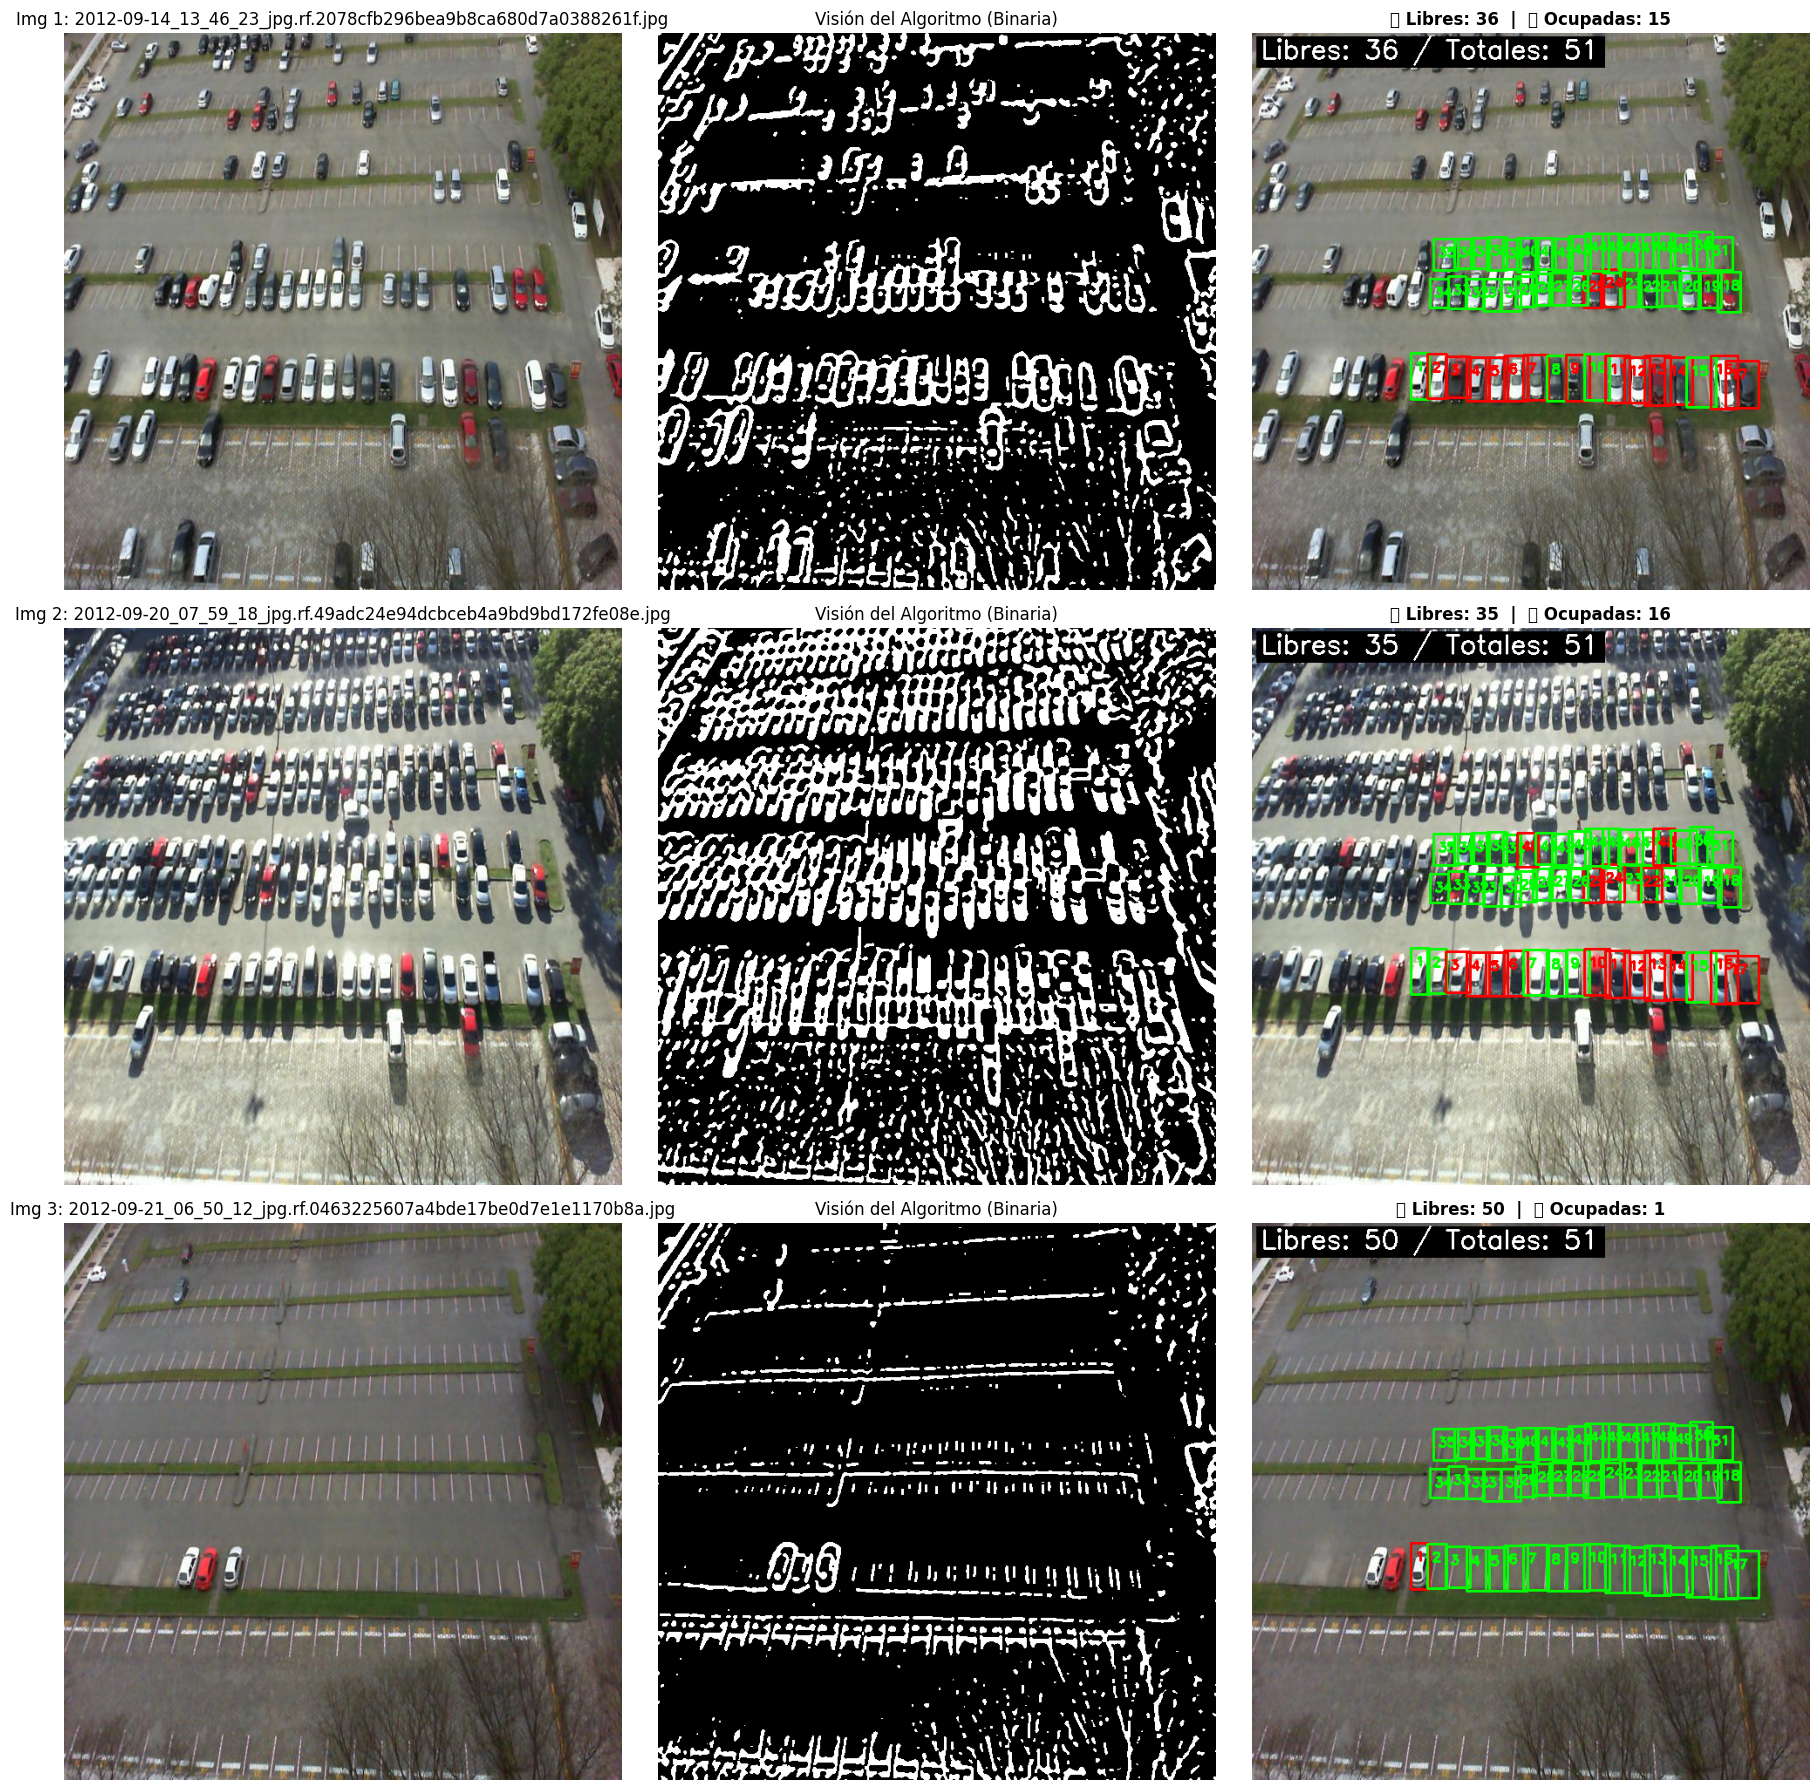

In [31]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np

# Cargar imágenes
data_dir = Path("data")
image_files = sorted(list(data_dir.glob("*.jpg")))

if len(image_files) == 0:
    print("❌ No se encontraron imágenes en la carpeta 'data'")
else:
    # 1. Configuración de la selección aleatoria
    cantidad_a_probar = 3
    n_muestras = min(cantidad_a_probar, len(image_files))
    
    # Seleccionamos archivos al azar
    muestras_random = random.sample(image_files, n_muestras)
    
    print(f"📸 Procesando {n_muestras} imágenes aleatorias...\n")

    # Crear figura (Filas = n_muestras, Columnas = 3)
    # Aumentamos un poco la altura para que quepan bien los títulos
    fig, axes = plt.subplots(nrows=n_muestras, ncols=3, figsize=(18, 6 * n_muestras))
    
    if n_muestras == 1:
        axes = [axes]

    for i, image_path in enumerate(muestras_random):
        # Cargar imagen
        img_test = cv2.imread(str(image_path))
        
        # Ejecutar pipeline
        output, estados, libres, binary = pipeline_completo(
            img_test, 
            plazas, 
            umbral_pixeles=500,
            block_size=21,
            C=5,
            show_counts=False 
        )
        
        # --- CÁLCULOS DE ESTADO ---
        total_plazas = len(plazas)
        ocupadas = total_plazas - libres
        # --------------------------

        ax_fila = axes[i] 
        
        # 1. Imagen Original
        ax_fila[0].imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
        ax_fila[0].set_title(f"Img {i+1}: {image_path.name}")
        ax_fila[0].axis('off')
        
        # 2. Máscara Binaria
        ax_fila[1].imshow(binary, cmap='gray')
        ax_fila[1].set_title("Visión del Algoritmo (Binaria)")
        ax_fila[1].axis('off')
        
        # 3. Resultado Final con el conteo detallado
        ax_fila[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        
        # Creamos un título informativo con salto de línea (\n) para que se lea mejor
        titulo_estado = (f"🟢 Libres: {libres}  |  🔴 Ocupadas: {ocupadas}")
        
        ax_fila[2].set_title(titulo_estado, fontsize=12, fontweight='bold')
        ax_fila[2].axis('off')
        
        # Imprimir resumen en texto
        print(f"✅ Imagen {i+1} ({image_path.name}): "
              f"Totales: {total_plazas}, Libres: {libres}, Ocupadas: {ocupadas}")

    plt.tight_layout()
    plt.show()

### 6A. Análisis Detallado de Plaza Específica

⚠️ **Si detectas falsos negativos** (plazas con coche detectadas como LIBRE), esta sección te ayudará a diagnosticar y corregir el problema.

Si identificaste una plaza problemática (ej. plaza 26), en la imagen "2012-09-20_07_54_18_jpg.rf.38bb40e59726cae985498264813dd63c.jpg", analízala en detalle aquí.

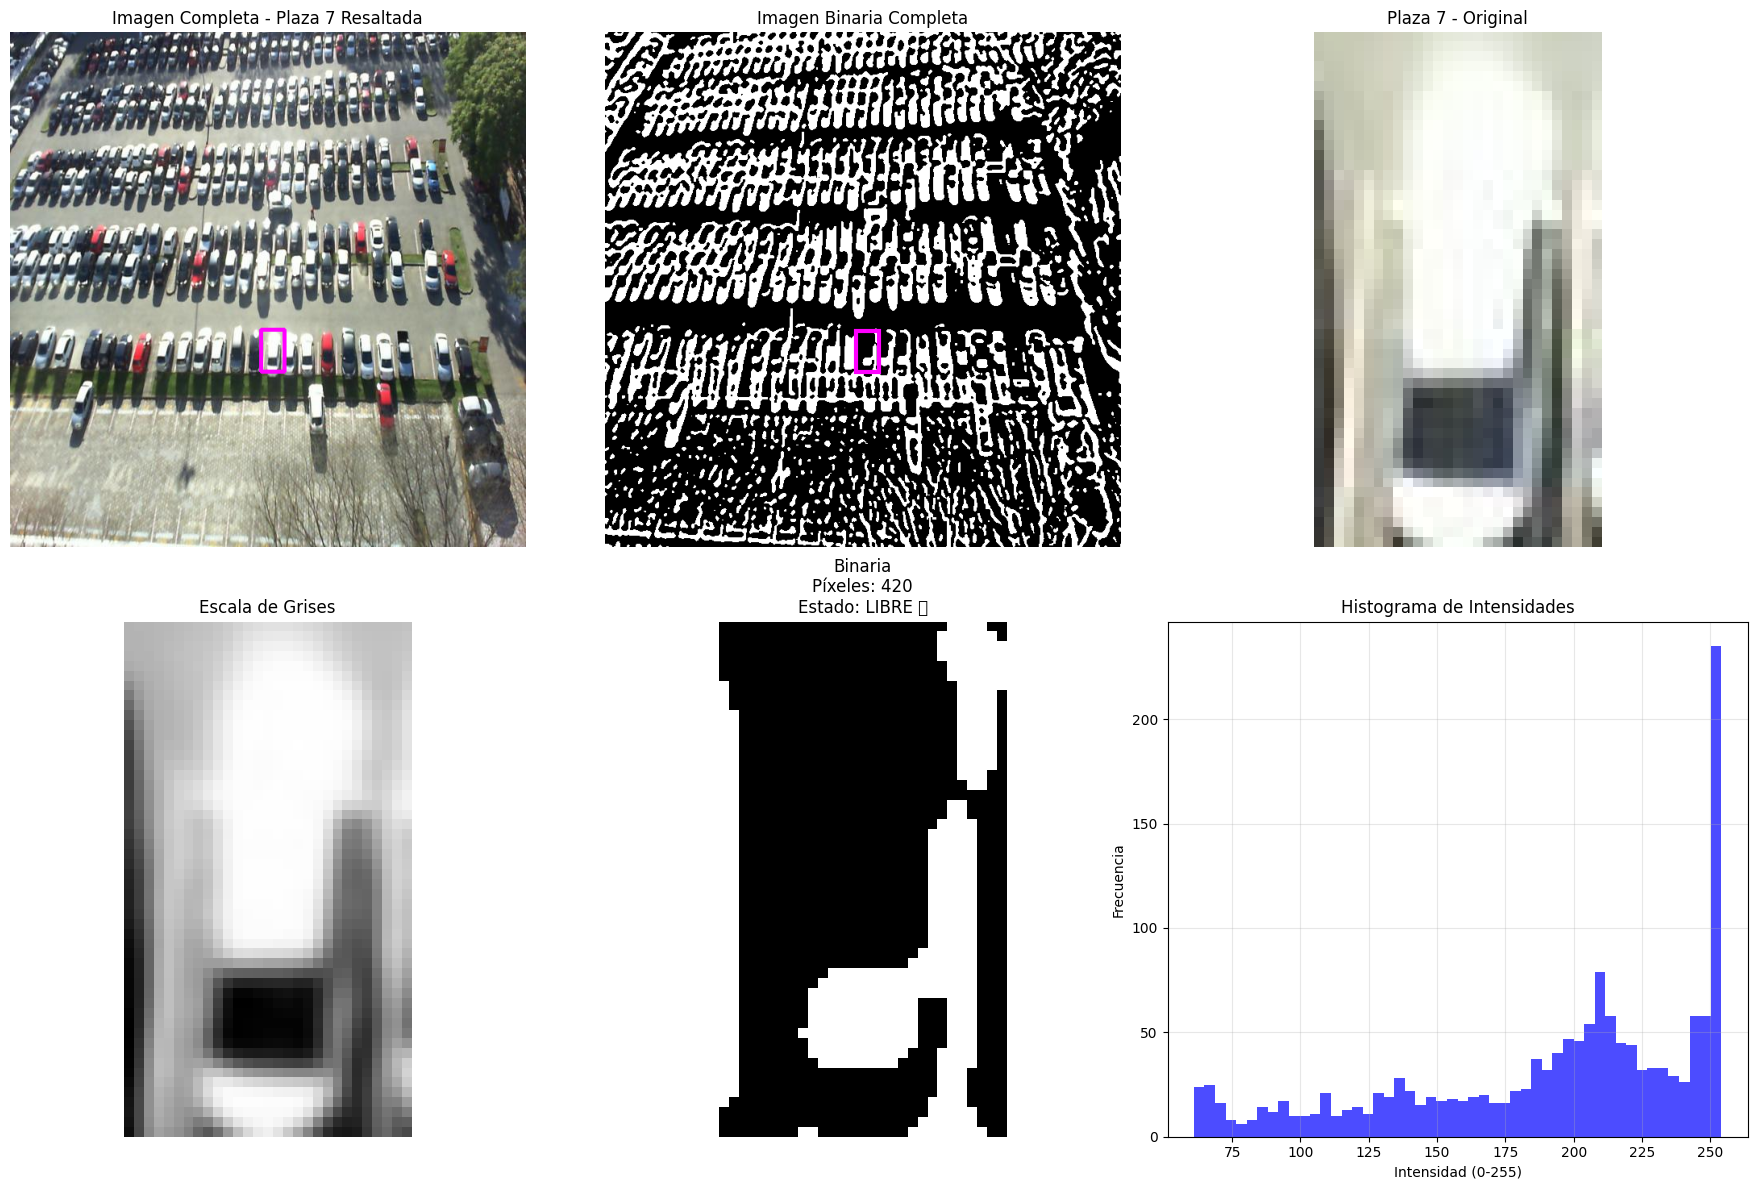


🔍 ANÁLISIS PLAZA 7:
   Píxeles blancos: 420
   Umbral actual: 500
   Estado detectado: LIBRE ❌
   ⚠️ Diferencia: 80 píxeles POR DEBAJO del umbral
   💡 Esta plaza probablemente tiene un coche pero no se detecta (FALSO NEGATIVO)


In [32]:
# 🔧 CONFIGURACIÓN: Cambia este número a la plaza que quieres analizar
PLAZA_A_ANALIZAR = 7  # Cambia según plaza e imagen de cada caso
img_t = cv2.imread("data/2012-09-20_07_59_18_jpg.rf.49adc24e94dcbceb4a9bd9bd172fe08e.jpg")

# Obtener coordenadas de la plaza
plaza_idx = PLAZA_A_ANALIZAR - 1  # 0-based
x, y, w, h = plazas[plaza_idx]

# Procesar imagen
blur = preprocesar_imagen(img_t)
binary_plaza = umbralizar_adaptativo(blur, 21, 5)
cleaned_plaza = filtro_mediana(binary_plaza)

# Extraer ROI
roi_original = img_t[y:y+h, x:x+w]
roi_gray = blur[y:y+h, x:x+w]
roi_binary = cleaned_plaza[y:y+h, x:x+w]
pixel_count_plaza = cv2.countNonZero(roi_binary)

# Visualización detallada
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Fila 1: Contexto completo
img_contexto = img_t.copy()
cv2.rectangle(img_contexto, (x, y), (x+w, y+h), (255, 0, 255), 4)
axes[0, 0].imshow(cv2.cvtColor(img_contexto, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"Imagen Completa - Plaza {PLAZA_A_ANALIZAR} Resaltada")
axes[0, 0].axis('off')

axes[0, 1].imshow(cleaned_plaza, cmap='gray')
axes[0, 1].add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='magenta', linewidth=3))
axes[0, 1].set_title("Imagen Binaria Completa")
axes[0, 1].axis('off')

axes[0, 2].imshow(cv2.cvtColor(roi_original, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title(f"Plaza {PLAZA_A_ANALIZAR} - Original")
axes[0, 2].axis('off')

# Fila 2: Análisis de la plaza
axes[1, 0].imshow(roi_gray, cmap='gray')
axes[1, 0].set_title("Escala de Grises")
axes[1, 0].axis('off')

axes[1, 1].imshow(roi_binary, cmap='gray')
estado_actual = 'OCUPADO ✅' if pixel_count_plaza > 500 else 'LIBRE ❌'
axes[1, 1].set_title(f"Binaria\nPíxeles: {pixel_count_plaza}\nEstado: {estado_actual}")
axes[1, 1].axis('off')

axes[1, 2].hist(roi_gray.ravel(), bins=50, color='blue', alpha=0.7)
axes[1, 2].set_title("Histograma de Intensidades")
axes[1, 2].set_xlabel("Intensidad (0-255)")
axes[1, 2].set_ylabel("Frecuencia")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔍 ANÁLISIS PLAZA {PLAZA_A_ANALIZAR}:")
print(f"   Píxeles blancos: {pixel_count_plaza}")
print(f"   Umbral actual: 500")
print(f"   Estado detectado: {estado_actual}")
if pixel_count_plaza < 500:
    print(f"   ⚠️ Diferencia: {500 - pixel_count_plaza} píxeles POR DEBAJO del umbral")
    print(f"   💡 Esta plaza probablemente tiene un coche pero no se detecta (FALSO NEGATIVO)")
else:
    print(f"   ✅ Diferencia: {pixel_count_plaza - 500} píxeles POR ENCIMA del umbral")

### 6B. Prueba de Diferentes Configuraciones

Prueba múltiples combinaciones de parámetros para encontrar la configuración óptima de la plaza seleccionada en el bloque anterior.

In [33]:
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

# Seleccionamos una imagen difícil para calibrar
# (Asegúrate de que 'img_t' y 'plazas' estén cargados)
img_calibracion = img_t.copy() 

def calibrar_parametros(umbral_px, block_size, c_const):
    # Validaciones para evitar errores
    if block_size % 2 == 0: block_size += 1 # Block size debe ser impar
    if block_size < 3: block_size = 3
    
    # Ejecutamos pipeline con los valores de los sliders
    output, _, libres, binary = pipeline_completo(
        img_calibracion, 
        plazas, 
        umbral_pixeles=umbral_px,
        block_size=block_size,
        C=c_const,
        show_counts=False
    )
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Ver la máscara binaria (lo que ve la IA)
    axes[0].imshow(binary, cmap='gray')
    axes[0].set_title(f"Máscara Binaria\nBlock: {block_size}, C: {c_const}")
    axes[0].axis('off')
    
    # Ver el resultado final
    axes[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Detección Final\nUmbral Pixeles: {umbral_px} | Libres: {libres}")
    axes[1].axis('off')
    
    plt.show()

# Crear los deslizadores
print("🎛️ Mueve los controles para calibrar en tiempo real:")
interact(calibrar_parametros,
         umbral_px=IntSlider(min=100, max=1000, step=10, value=500, description='Umbral Px'),
         block_size=IntSlider(min=3, max=51, step=2, value=21, description='Block Size'),
         c_const=IntSlider(min=0, max=30, step=1, value=5, description='Constante C')
);

🎛️ Mueve los controles para calibrar en tiempo real:


interactive(children=(IntSlider(value=500, description='Umbral Px', max=1000, min=100, step=10), IntSlider(val…

### 6C. Comparación Visual de Configuraciones

Visualiza lado a lado el resultado con parámetros originales vs mejorados.

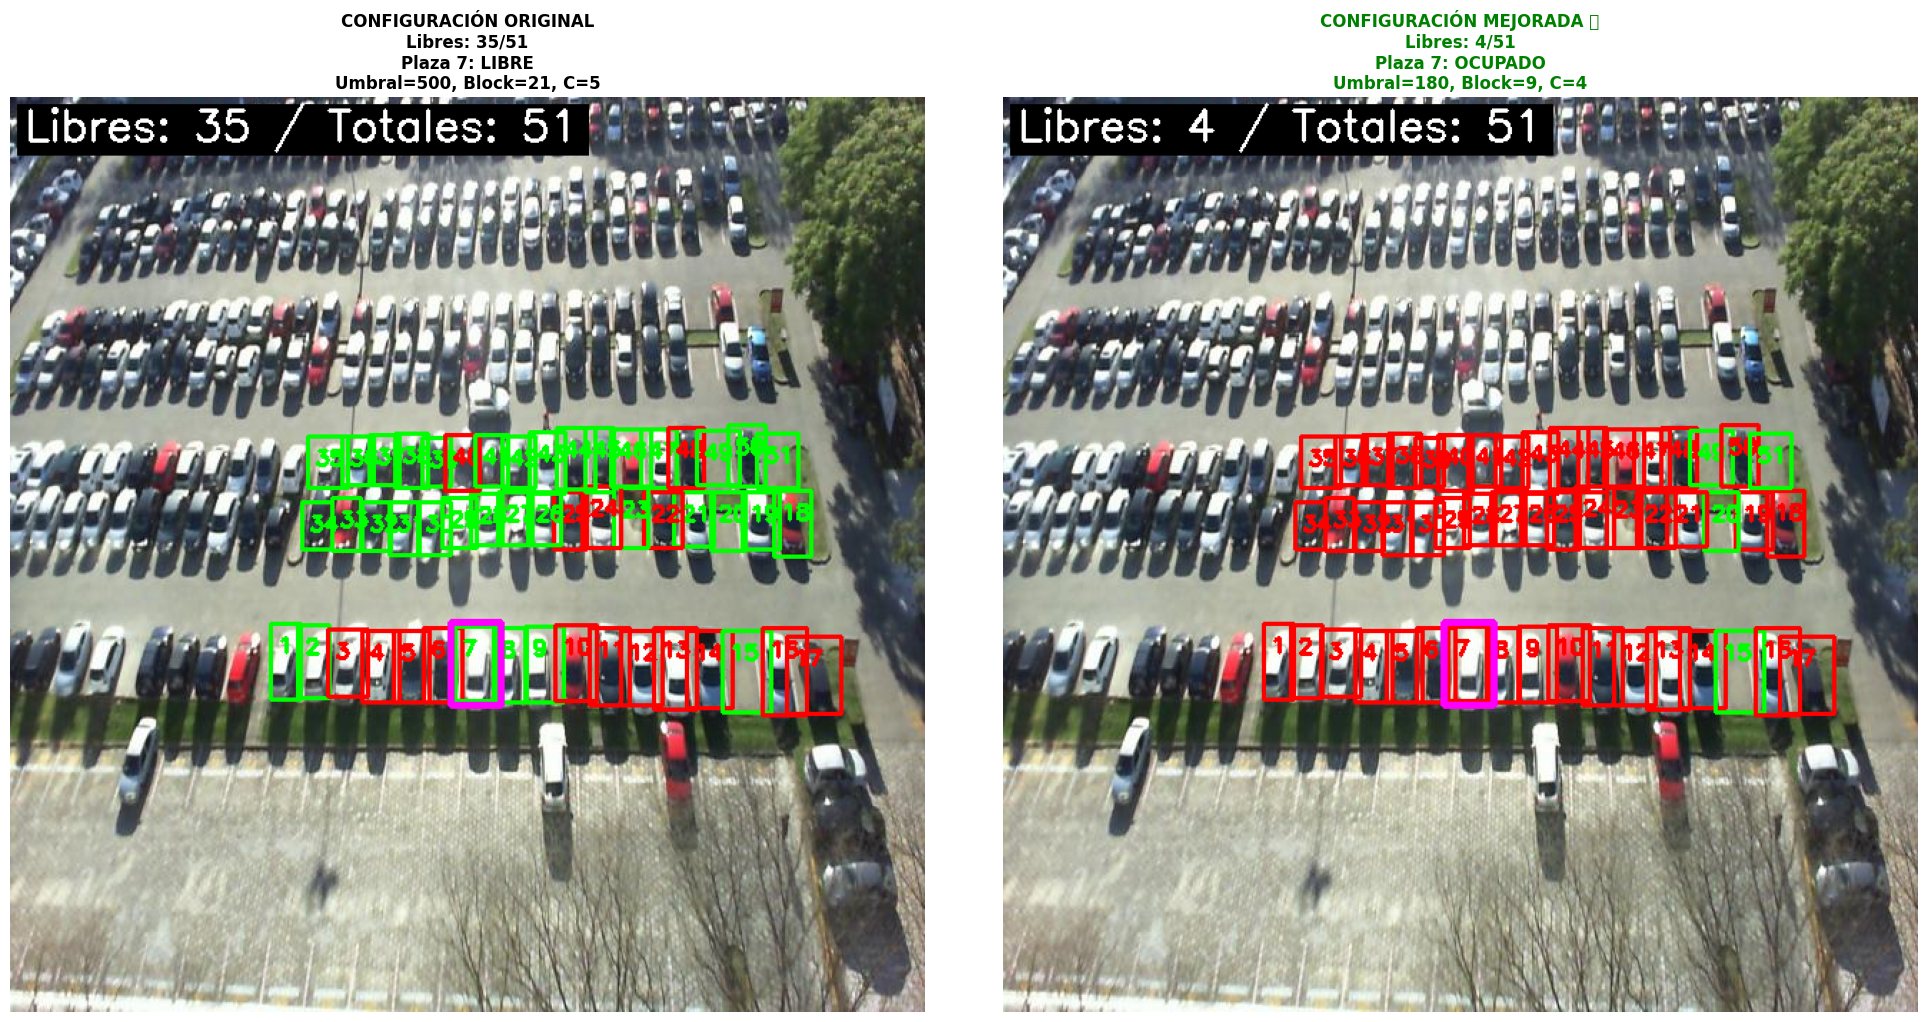


📊 COMPARACIÓN DE RESULTADOS

Configuración Original:
  Parámetros: umbral=500, block_size=21, C=5
  Plaza 7: LIBRE
  Total libres: 35/51

Configuración Mejorada:
  Parámetros: umbral=180, block_size=9, C=4
  Plaza 7: OCUPADO ✅
  Total libres: 4/51

📈 Cambios en detección: 31 plaza(s) cambiaron de estado

Plazas que cambiaron:
  Plaza 1: LIBRE → OCUPADO
  Plaza 2: LIBRE → OCUPADO
  Plaza 7: LIBRE → OCUPADO
  Plaza 8: LIBRE → OCUPADO
  Plaza 9: LIBRE → OCUPADO
  Plaza 18: LIBRE → OCUPADO
  Plaza 19: LIBRE → OCUPADO
  Plaza 21: LIBRE → OCUPADO
  Plaza 23: LIBRE → OCUPADO
  Plaza 26: LIBRE → OCUPADO
  Plaza 27: LIBRE → OCUPADO
  Plaza 28: LIBRE → OCUPADO
  Plaza 29: LIBRE → OCUPADO
  Plaza 30: LIBRE → OCUPADO
  Plaza 31: LIBRE → OCUPADO
  Plaza 32: LIBRE → OCUPADO
  Plaza 33: LIBRE → OCUPADO
  Plaza 34: LIBRE → OCUPADO
  Plaza 35: LIBRE → OCUPADO
  Plaza 36: LIBRE → OCUPADO
  Plaza 37: LIBRE → OCUPADO
  Plaza 38: LIBRE → OCUPADO
  Plaza 39: LIBRE → OCUPADO
  Plaza 41: LIBRE → OCUPADO
  Pl

In [34]:
# 🔧 CONFIGURACIÓN: Ajusta estos valores según los resultados de la celda anterior
UMBRAL_MEJORADO = 180  # Cambiar según tu análisis
BLOCK_SIZE_MEJORADO = 9
C_MEJORADO = 4

# Procesar con configuración original
output_orig, estados_orig, libres_orig, binary_orig = pipeline_completo(
    img_t, plazas, 500, 21, 5, show_counts=False
)

# Procesar con configuración mejorada
output_mejor, estados_mejor, libres_mejor, binary_mejor = pipeline_completo(
    img_t, plazas, UMBRAL_MEJORADO, BLOCK_SIZE_MEJORADO, C_MEJORADO, show_counts=False
)

# Resaltar plaza analizada
x, y, w, h = plazas[PLAZA_A_ANALIZAR - 1]
cv2.rectangle(output_orig, (x-3, y-3), (x+w+3, y+h+3), (255, 0, 255), 4)
cv2.rectangle(output_mejor, (x-3, y-3), (x+w+3, y+h+3), (255, 0, 255), 4)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cv2.cvtColor(output_orig, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"CONFIGURACIÓN ORIGINAL\nLibres: {libres_orig}/{len(plazas)}\nPlaza {PLAZA_A_ANALIZAR}: {estados_orig[PLAZA_A_ANALIZAR-1]}\nUmbral=500, Block=21, C=5", 
                 fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(output_mejor, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"CONFIGURACIÓN MEJORADA ✅\nLibres: {libres_mejor}/{len(plazas)}\nPlaza {PLAZA_A_ANALIZAR}: {estados_mejor[PLAZA_A_ANALIZAR-1]}\nUmbral={UMBRAL_MEJORADO}, Block={BLOCK_SIZE_MEJORADO}, C={C_MEJORADO}",
                 fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Comparación de resultados
print("\n" + "="*60)
print("📊 COMPARACIÓN DE RESULTADOS")
print("="*60)
print(f"\nConfiguración Original:")
print(f"  Parámetros: umbral=500, block_size=21, C=5")
print(f"  Plaza {PLAZA_A_ANALIZAR}: {estados_orig[PLAZA_A_ANALIZAR-1]}")
print(f"  Total libres: {libres_orig}/{len(plazas)}")

print(f"\nConfiguración Mejorada:")
print(f"  Parámetros: umbral={UMBRAL_MEJORADO}, block_size={BLOCK_SIZE_MEJORADO}, C={C_MEJORADO}")
print(f"  Plaza {PLAZA_A_ANALIZAR}: {estados_mejor[PLAZA_A_ANALIZAR-1]} ✅")
print(f"  Total libres: {libres_mejor}/{len(plazas)}")

# Diferencias
cambios = sum(1 for i in range(len(estados_orig)) if estados_orig[i] != estados_mejor[i])
print(f"\n📈 Cambios en detección: {cambios} plaza(s) cambiaron de estado")

if cambios > 0:
    print(f"\nPlazas que cambiaron:")
    for i in range(len(estados_orig)):
        if estados_orig[i] != estados_mejor[i]:
            print(f"  Plaza {i+1}: {estados_orig[i]} → {estados_mejor[i]}")

print("="*60)

print("\n💡 RECOMENDACIÓN:")
print(f"   Si la configuración mejorada detecta correctamente la plaza {PLAZA_A_ANALIZAR},")
print(f"   usa estos parámetros en las siguientes celdas del notebook:")
print(f"   umbral_pixeles={UMBRAL_MEJORADO}, block_size={BLOCK_SIZE_MEJORADO}, C={C_MEJORADO}")

In [1]:
# 1. Definir la "Verdad" (Ground Truth) para tus 3 imágenes de prueba
# Esto debes llenarlo tú mirando las fotos originales. 
# Ejemplo: "En la foto 1 hay 15 libres, en la foto 2 hay 12..."
# O idealmente, saber plaza por plaza, pero para empezar usaremos el conteo total.

# Supongamos que tus parámetros ganadores fueron estos:
MEJOR_UMBRAL = 350
MEJOR_BLOCK = 23
MEJOR_C = 3

# Imágenes de prueba (ruta) y su realidad (cuántas libres hay de verdad)
# Tienes que mirar las fotos y poner el número real aquí:
set_validacion = [
    {"archivo": image_files[10], "real_libres": 12}, # Ejemplo: índice 10
    {"archivo": image_files[25], "real_libres": 8},  # Ejemplo: índice 25
    {"archivo": image_files[40], "real_libres": 15}  # Ejemplo: índice 40
]

print(f"{'IMAGEN':<20} | {'REAL':<10} | {'DETECTADO':<10} | {'ERROR':<10} | {'PRECISIÓN'}")
print("-" * 75)

total_error = 0

for item in set_validacion:
    # Cargar
    img_val = cv2.imread(str(item["archivo"]))
    real = item["real_libres"]
    
    # Predecir con tus mejores parámetros
    _, _, detectado, _ = pipeline_completo(
        img_val, plazas, 
        umbral_pixeles=MEJOR_UMBRAL, 
        block_size=MEJOR_BLOCK, 
        C=MEJOR_C, 
        show_counts=False
    )
    
    # Calcular error
    error = detectado - real
    precision = 100 - (abs(error) / len(plazas) * 100) # Precisión simple
    
    # Mostrar fila
    estado = "✅" if error == 0 else "⚠️"
    print(f"{item['archivo'].name:<20} | {real:<10} | {detectado:<10} | {error:<10} | {precision:.1f}% {estado}")

NameError: name 'image_files' is not defined

---
## 10. Posibles Conclusiones y Análisis

### Justificaciones Técnicas para la Memoria

1. **Selección de ROI**: Se descartaron las plazas perimetrales para evitar errores por oclusión parcial (árboles) y distorsión de lente en los bordes.

2. **Umbralización Adaptativa vs. Global**: Frente a métodos globales como Otsu, se eligió umbralización adaptativa para mitigar el fuerte contraste provocado por las sombras de los edificios.

3. **Complejidad Computacional**: El algoritmo propuesto tiene complejidad $O(N)$ (lineal con el número de píxeles), permitiendo su ejecución en tiempo real en hardware modesto.

4. **Robustez a Iluminación**: La ventana local del adaptive threshold hace que cada píxel se compare con su vecindad inmediata, no con el promedio global de la imagen, lo que permite funcionar correctamente incluso cuando mitad del parking está en sombra.

### Limitaciones Conocidas

- **Motos/Bicicletas**: Vehículos muy pequeños pueden no generar suficiente textura.
- **Oclusiones Parciales**: Vehículos estacionados fuera de las líneas pueden afectar plazas adyacentes.
- **Condiciones Extremas**: Lluvia, nieve o niebla no fueron probadas.

### Posibles Mejoras Futuras

1. Ajuste automático de parámetros basado en hora del día
2. Tracking temporal (si un coche entra, es más probable que esté ocupado en frames siguientes)
3. Detección de líneas de parking para validación geométrica


---
## 🎯 Checklist de Completación del Proyecto

- [ ] Configurar plazas con `configurar_plazas.py` (51 ROIs)
- [ ] Ejecutar pipeline con imagen de prueba
- [ ] Calibrar parámetros con trackbars (opcional pero recomendado)
- [ ] Procesar dataset completo (batch processing)
- [ ] Seleccionar 3 imágenes de validación
- [ ] Etiquetar ground truth manualmente
- [ ] Calcular métricas (TP, TN, FP, FN, Accuracy)
- [ ] Documentar resultados en la memoria
- [ ] Preparar visualizaciones para la defensa

---

**Autor**: Proyecto Individual - Fundamentos de Visión por Computador  
**Metodología**: Computer Vision Clásica (Adaptive Thresholding + Morphological Operations)  
**Dataset**: ~440 imágenes de parking exterior  